# Method 3 - Best Minus Rest Top 5

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)
                                                                                         
# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] <= 5].copy()                                                                                         
short_ideas = valid_data[valid_data['pos_rank'] > 5].copy()

# Weight the best ideas

long_ideas['target'] = long_ideas['target'] / long_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / long_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

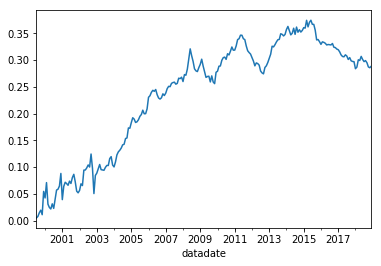

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.054474
2000-12-31    0.031831
2001-12-31   -0.033300
2002-12-31    0.030873
2003-12-31    0.017992
2004-12-31    0.062321
2005-12-31    0.030921
2006-12-31    0.020575
2007-12-31    0.027829
2008-12-31    0.014082
2009-12-31   -0.006752
2010-12-31    0.032306
2011-12-31   -0.005527
2012-12-31   -0.012022
2013-12-31    0.040476
2014-12-31    0.005585
2015-12-31   -0.015518
2016-12-31   -0.010268
2017-12-31   -0.017941
2018-12-31   -0.006526
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     28.23
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.54e-19
Time:                        13:14:58   Log-Likelihood:                 808.99
No. Observations:                 234   AIC:                            -1608.
Df Residuals:                     229   BIC:                            -1591.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.427      0.670      -0.001       0.001
mktrf         -0.0219      0.014     -1.521      0.130      -0.050       0.006
me             0.1610      0.017      9.625      0.000       0.128       0.194
ia            -0.0484      0.025     -1.903      0.058      -0.098       0.002
roe            0.1262      0.022      5.798      0.000       0.083       0.169
==============================================================================
Omnibus:                       41.700   Durbin-Watson:                   2.226
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              425.905
Skew:                          -0.121   Prob(JB):                     3.28e-93
Kurtosis:                       9.605   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     25.31
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.27e-17
Time:                        13:14:58   Log-Likelihood:                 808.99
No. Observations:                 234   AIC:                            -1608.
Df Residuals:                     229   BIC:                            -1591.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.395      0.693      -0.001       0.001
mktrf         -0.0219      0.018     -1.207      0.227      -0.057       0.014
me             0.1610      0.016      9.986      0.000       0.129       0.193
ia            -0.0484      0.054     -0.890      0.374      -0.155       0.058
roe            0.1262      0.042      2.984      0.003       0.043       0.209
==============================================================================
Omnibus:                       41.700   Durbin-Watson:                   2.226
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              425.905
Skew:                          -0.121   Prob(JB):                     3.28e-93
Kurtosis:                       9.605   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     29.18
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.30e-19
Time:                        13:14:58   Log-Likelihood:                 808.99
No. Observations:                 234   AIC:                            -1608.
Df Residuals:                     229   BIC:                            -1591.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.361      0.718      -0.001       0.001
mktrf         -0.0219      0.018     -1.229      0.219      -0.057       0.013
me             0.1610      0.015     10.430      0.000       0.131       0.191
ia            -0.0484      0.051     -0.952      0.341      -0.148       0.051
roe            0.1262      0.043      2.916      0.004       0.041       0.211
==============================================================================
Omnibus:                       41.700   Durbin-Watson:                   2.226
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              425.905
Skew:                          -0.121   Prob(JB):                     3.28e-93
Kurtosis:                       9.605   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     15.51
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.97e-13
Time:                        13:14:58   Log-Likelihood:                 796.34
No. Observations:                 234   AIC:                            -1581.
Df Residuals:                     228   BIC:                            -1560.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.864      0.388      -0.001       0.002
mktrf         -0.0392      0.015     -2.571      0.011      -0.069      -0.009
smb            0.1629      0.020      8.102      0.000       0.123       0.203
hml           -0.0387      0.024     -1.630      0.104      -0.085       0.008
rmw            0.0911      0.027      3.399      0.001       0.038       0.144
cma            0.0009      0.034      0.027      0.979      -0.066       0.068
==============================================================================
Omnibus:                       78.395   Durbin-Watson:                   2.330
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1141.410
Skew:                          -0.844   Prob(JB):                    1.40e-248
Kurtosis:                      13.687   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     21.44
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.45e-17
Time:                        13:14:58   Log-Likelihood:                 796.34
No. Observations:                 234   AIC:                            -1581.
Df Residuals:                     228   BIC:                            -1560.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.808      0.419      -0.001       0.002
mktrf         -0.0392      0.018     -2.127      0.033      -0.075      -0.003
smb            0.1629      0.031      5.209      0.000       0.102       0.224
hml           -0.0387      0.030     -1.297      0.195      -0.097       0.020
rmw            0.0911      0.046      1.961      0.050     3.3e-05       0.182
cma            0.0009      0.096      0.010      0.992      -0.187       0.189
==============================================================================
Omnibus:                       78.395   Durbin-Watson:                   2.330
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1141.410
Skew:                          -0.844   Prob(JB):                    1.40e-248
Kurtosis:                      13.687   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     29.27
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.60e-23
Time:                        13:14:58   Log-Likelihood:                 796.34
No. Observations:                 234   AIC:                            -1581.
Df Residuals:                     228   BIC:                            -1560.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.745      0.456      -0.001       0.002
mktrf         -0.0392      0.018     -2.203      0.028      -0.074      -0.004
smb            0.1629      0.029      5.524      0.000       0.105       0.221
hml           -0.0387      0.032     -1.207      0.227      -0.101       0.024
rmw            0.0911      0.050      1.825      0.068      -0.007       0.189
cma            0.0009      0.098      0.009      0.993      -0.191       0.193
==============================================================================
Omnibus:                       78.395   Durbin-Watson:                   2.330
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1141.410
Skew:                          -0.844   Prob(JB):                    1.40e-248
Kurtosis:                      13.687   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     56.23
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.46e-33
Time:                        13:14:58   Log-Likelihood:                 842.15
No. Observations:                 234   AIC:                            -1674.
Df Residuals:                     229   BIC:                            -1657.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.754      0.452      -0.001       0.001
mktrf         -0.0077      0.011     -0.669      0.504      -0.030       0.015
smb            0.0841      0.014      5.862      0.000       0.056       0.112
hml            0.0428      0.014      3.007      0.003       0.015       0.071
umd            0.1076      0.009     11.507      0.000       0.089       0.126
==============================================================================
Omnibus:                       24.557   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.730
Skew:                          -0.319   Prob(JB):                     1.09e-18
Kurtosis:                       5.842   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     36.78
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.68e-24
Time:                        13:14:58   Log-Likelihood:                 842.15
No. Observations:                 234   AIC:                            -1674.
Df Residuals:                     229   BIC:                            -1657.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.684      0.494      -0.001       0.001
mktrf         -0.0077      0.017     -0.465      0.642      -0.040       0.025
smb            0.0841      0.020      4.115      0.000       0.044       0.124
hml            0.0428      0.016      2.668      0.008       0.011       0.074
umd            0.1076      0.021      5.073      0.000       0.066       0.149
==============================================================================
Omnibus:                       24.557   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.730
Skew:                          -0.319   Prob(JB):                     1.09e-18
Kurtosis:                       5.842   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.487
Method:                 Least Squares   F-statistic:                     48.93
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.03e-29
Time:                        13:14:58   Log-Likelihood:                 842.15
No. Observations:                 234   AIC:                            -1674.
Df Residuals:                     229   BIC:                            -1657.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.623      0.533      -0.001       0.001
mktrf         -0.0077      0.016     -0.472      0.637      -0.040       0.024
smb            0.0841      0.023      3.708      0.000       0.040       0.129
hml            0.0428      0.014      3.122      0.002       0.016       0.070
umd            0.1076      0.022      4.792      0.000       0.064       0.152
==============================================================================
Omnibus:                       24.557   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.730
Skew:                          -0.319   Prob(JB):                     1.09e-18
Kurtosis:                       5.842   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     19.62
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.48e-12
Time:                        13:14:58   Log-Likelihood:                 393.16
No. Observations:                 120   AIC:                            -776.3
Df Residuals:                     115   BIC:                            -762.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.729e-05      0.001      0.098      0.922      -0.002       0.002
mktrf          0.0127      0.024      0.529      0.598      -0.035       0.060
me             0.1735      0.024      7.302      0.000       0.126       0.221
ia            -0.0776      0.037     -2.085      0.039      -0.151      -0.004
roe            0.2024      0.033      6.146      0.000       0.137       0.268
==============================================================================
Omnibus:                       18.825   Durbin-Watson:                   2.293
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.848
Skew:                          -0.074   Prob(JB):                     4.18e-21
Kurtosis:                       7.330   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     25.57
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.62e-15
Time:                        13:14:58   Log-Likelihood:                 393.16
No. Observations:                 120   AIC:                            -776.3
Df Residuals:                     115   BIC:                            -762.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.729e-05      0.001      0.108      0.914      -0.001       0.002
mktrf          0.0127      0.026      0.499      0.618      -0.037       0.063
me             0.1735      0.020      8.751      0.000       0.135       0.212
ia            -0.0776      0.069     -1.128      0.259      -0.212       0.057
roe            0.2024      0.047      4.271      0.000       0.110       0.295
==============================================================================
Omnibus:                       18.825   Durbin-Watson:                   2.293
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.848
Skew:                          -0.074   Prob(JB):                     4.18e-21
Kurtosis:                       7.330   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     31.50
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.04e-17
Time:                        13:14:58   Log-Likelihood:                 393.16
No. Observations:                 120   AIC:                            -776.3
Df Residuals:                     115   BIC:                            -762.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.729e-05      0.001      0.096      0.924      -0.002       0.002
mktrf          0.0127      0.019      0.675      0.500      -0.024       0.050
me             0.1735      0.020      8.750      0.000       0.135       0.212
ia            -0.0776      0.064     -1.210      0.226      -0.203       0.048
roe            0.2024      0.039      5.231      0.000       0.127       0.278
==============================================================================
Omnibus:                       18.825   Durbin-Watson:                   2.293
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               93.848
Skew:                          -0.074   Prob(JB):                     4.18e-21
Kurtosis:                       7.330   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     6.927
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.11e-05
Time:                        13:14:58   Log-Likelihood:                 377.86
No. Observations:                 120   AIC:                            -743.7
Df Residuals:                     114   BIC:                            -727.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.397      0.692      -0.002       0.002
mktrf         -0.0306      0.029     -1.058      0.292      -0.088       0.027
smb            0.1675      0.033      5.110      0.000       0.103       0.232
hml           -0.0651      0.040     -1.620      0.108      -0.145       0.015
rmw            0.1297      0.047      2.737      0.007       0.036       0.224
cma            0.0048      0.052      0.092      0.927      -0.098       0.108
==============================================================================
Omnibus:                       34.712   Durbin-Watson:                   2.457
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              204.742
Skew:                          -0.736   Prob(JB):                     3.47e-45
Kurtosis:                       9.228   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     14.76
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.77e-11
Time:                        13:14:58   Log-Likelihood:                 377.86
No. Observations:                 120   AIC:                            -743.7
Df Residuals:                     114   BIC:                            -727.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.421      0.674      -0.002       0.002
mktrf         -0.0306      0.033     -0.922      0.357      -0.096       0.034
smb            0.1675      0.045      3.747      0.000       0.080       0.255
hml           -0.0651      0.034     -1.927      0.054      -0.131       0.001
rmw            0.1297      0.062      2.076      0.038       0.007       0.252
cma            0.0048      0.123      0.039      0.969      -0.236       0.246
==============================================================================
Omnibus:                       34.712   Durbin-Watson:                   2.457
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              204.742
Skew:                          -0.736   Prob(JB):                     3.47e-45
Kurtosis:                       9.228   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     17.34
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.83e-13
Time:                        13:14:58   Log-Likelihood:                 377.86
No. Observations:                 120   AIC:                            -743.7
Df Residuals:                     114   BIC:                            -727.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.372      0.710      -0.002       0.003
mktrf         -0.0306      0.032     -0.967      0.334      -0.093       0.031
smb            0.1675      0.042      4.007      0.000       0.086       0.249
hml           -0.0651      0.036     -1.824      0.068      -0.135       0.005
rmw            0.1297      0.066      1.956      0.050      -0.000       0.260
cma            0.0048      0.125      0.038      0.970      -0.241       0.250
==============================================================================
Omnibus:                       34.712   Durbin-Watson:                   2.457
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              204.742
Skew:                          -0.736   Prob(JB):                     3.47e-45
Kurtosis:                       9.228   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     36.19
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.48e-19
Time:                        13:14:58   Log-Likelihood:                 410.84
No. Observations:                 120   AIC:                            -811.7
Df Residuals:                     115   BIC:                            -797.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.103      0.272      -0.001       0.002
mktrf          0.0136      0.018      0.746      0.457      -0.023       0.050
smb            0.0508      0.021      2.437      0.016       0.010       0.092
hml            0.0382      0.021      1.829      0.070      -0.003       0.079
umd            0.1284      0.013      9.985      0.000       0.103       0.154
==============================================================================
Omnibus:                        8.400   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               12.750
Skew:                          -0.304   Prob(JB):                      0.00170
Kurtosis:                       4.477   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     25.47
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.02e-15
Time:                        13:14:58   Log-Likelihood:                 410.84
No. Observations:                 120   AIC:                            -811.7
Df Residuals:                     115   BIC:                            -797.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.181      0.237      -0.001       0.002
mktrf          0.0136      0.022      0.629      0.530      -0.029       0.056
smb            0.0508      0.021      2.423      0.015       0.010       0.092
hml            0.0382      0.016      2.382      0.017       0.007       0.070
umd            0.1284      0.024      5.440      0.000       0.082       0.175
==============================================================================
Omnibus:                        8.400   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               12.750
Skew:                          -0.304   Prob(JB):                      0.00170
Kurtosis:                       4.477   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     38.77
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.63e-20
Time:                        13:14:58   Log-Likelihood:                 410.84
No. Observations:                 120   AIC:                            -811.7
Df Residuals:                     115   BIC:                            -797.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.108      0.268      -0.001       0.002
mktrf          0.0136      0.018      0.746      0.455      -0.022       0.049
smb            0.0508      0.018      2.802      0.005       0.015       0.086
hml            0.0382      0.011      3.337      0.001       0.016       0.061
umd            0.1284      0.023      5.664      0.000       0.084       0.173
==============================================================================
Omnibus:                        8.400   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               12.750
Skew:                          -0.304   Prob(JB):                      0.00170
Kurtosis:                       4.477   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     16.00
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.46e-10
Time:                        13:14:58   Log-Likelihood:                 461.17
No. Observations:                 114   AIC:                            -912.3
Df Residuals:                     109   BIC:                            -898.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      1.566      0.120      -0.000       0.002
mktrf         -0.0501      0.013     -3.932      0.000      -0.075      -0.025
me             0.1350      0.020      6.865      0.000       0.096       0.174
ia            -0.0340      0.027     -1.248      0.215      -0.088       0.020
roe           -0.0511      0.024     -2.134      0.035      -0.099      -0.004
==============================================================================
Omnibus:                        2.659   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.265   Jarque-Bera (JB):                2.444
Skew:                           0.358   Prob(JB):                        0.295
Kurtosis:                       2.978   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     20.61
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.14e-12
Time:                        13:14:58   Log-Likelihood:                 461.17
No. Observations:                 114   AIC:                            -912.3
Df Residuals:                     109   BIC:                            -898.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      1.190      0.234      -0.000       0.002
mktrf         -0.0501      0.010     -4.965      0.000      -0.070      -0.030
me             0.1350      0.021      6.525      0.000       0.094       0.176
ia            -0.0340      0.029     -1.183      0.237      -0.090       0.022
roe           -0.0511      0.026     -1.949      0.051      -0.103       0.000
==============================================================================
Omnibus:                        2.659   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.265   Jarque-Bera (JB):                2.444
Skew:                           0.358   Prob(JB):                        0.295
Kurtosis:                       2.978   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     22.35
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.70e-13
Time:                        13:14:58   Log-Likelihood:                 461.17
No. Observations:                 114   AIC:                            -912.3
Df Residuals:                     109   BIC:                            -898.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      1.072      0.284      -0.001       0.002
mktrf         -0.0501      0.010     -5.241      0.000      -0.069      -0.031
me             0.1350      0.019      7.074      0.000       0.098       0.172
ia            -0.0340      0.028     -1.212      0.226      -0.089       0.021
roe           -0.0511      0.028     -1.835      0.067      -0.106       0.003
==============================================================================
Omnibus:                        2.659   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.265   Jarque-Bera (JB):                2.444
Skew:                           0.358   Prob(JB):                        0.295
Kurtosis:                       2.978   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     16.67
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.56e-12
Time:                        13:14:58   Log-Likelihood:                 467.44
No. Observations:                 114   AIC:                            -922.9
Df Residuals:                     108   BIC:                            -906.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      1.303      0.195      -0.000       0.001
mktrf         -0.0409      0.012     -3.540      0.001      -0.064      -0.018
smb            0.1564      0.019      8.341      0.000       0.119       0.194
hml           -0.0464      0.024     -1.940      0.055      -0.094       0.001
rmw           -0.0208      0.029     -0.710      0.480      -0.079       0.037
cma            0.0155      0.037      0.417      0.678      -0.058       0.089
==============================================================================
Omnibus:                        4.944   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                4.439
Skew:                           0.469   Prob(JB):                        0.109
Kurtosis:                       3.235   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     35.18
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.30e-21
Time:                        13:14:58   Log-Likelihood:                 467.44
No. Observations:                 114   AIC:                            -922.9
Df Residuals:                     108   BIC:                            -906.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.992      0.321      -0.001       0.002
mktrf         -0.0409      0.010     -4.151      0.000      -0.060      -0.022
smb            0.1564      0.022      7.258      0.000       0.114       0.199
hml           -0.0464      0.018     -2.540      0.011      -0.082      -0.011
rmw           -0.0208      0.026     -0.785      0.433      -0.073       0.031
cma            0.0155      0.035      0.449      0.654      -0.052       0.083
==============================================================================
Omnibus:                        4.944   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                4.439
Skew:                           0.469   Prob(JB):                        0.109
Kurtosis:                       3.235   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     40.76
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.27e-23
Time:                        13:14:58   Log-Likelihood:                 467.44
No. Observations:                 114   AIC:                            -922.9
Df Residuals:                     108   BIC:                            -906.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.935      0.350      -0.001       0.002
mktrf         -0.0409      0.009     -4.381      0.000      -0.059      -0.023
smb            0.1564      0.021      7.486      0.000       0.115       0.197
hml           -0.0464      0.017     -2.794      0.005      -0.079      -0.014
rmw           -0.0208      0.026     -0.788      0.431      -0.072       0.031
cma            0.0155      0.031      0.501      0.616      -0.045       0.076
==============================================================================
Omnibus:                        4.944   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                4.439
Skew:                           0.469   Prob(JB):                        0.109
Kurtosis:                       3.235   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     23.14
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.35e-14
Time:                        13:14:58   Log-Likelihood:                 469.88
No. Observations:                 114   AIC:                            -929.8
Df Residuals:                     109   BIC:                            -916.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.924      0.358      -0.000       0.001
mktrf         -0.0343      0.011     -3.068      0.003      -0.056      -0.012
smb            0.1582      0.017      9.076      0.000       0.124       0.193
hml           -0.0038      0.018     -0.210      0.834      -0.039       0.032
umd            0.0333      0.014      2.455      0.016       0.006       0.060
==============================================================================
Omnibus:                        4.844   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                4.413
Skew:                           0.475   Prob(JB):                        0.110
Kurtosis:                       3.167   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     41.37
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.70e-21
Time:                        13:14:58   Log-Likelihood:                 469.88
No. Observations:                 114   AIC:                            -929.8
Df Residuals:                     109   BIC:                            -916.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.684      0.494      -0.001       0.001
mktrf         -0.0343      0.010     -3.299      0.001      -0.055      -0.014
smb            0.1582      0.017      9.565      0.000       0.126       0.191
hml           -0.0038      0.015     -0.256      0.798      -0.033       0.025
umd            0.0333      0.010      3.178      0.001       0.013       0.054
==============================================================================
Omnibus:                        4.844   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                4.413
Skew:                           0.475   Prob(JB):                        0.110
Kurtosis:                       3.167   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     39.13
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.80e-20
Time:                        13:14:58   Log-Likelihood:                 469.88
No. Observations:                 114   AIC:                            -929.8
Df Residuals:                     109   BIC:                            -916.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.654      0.513      -0.001       0.001
mktrf         -0.0343      0.010     -3.426      0.001      -0.054      -0.015
smb            0.1582      0.014     11.002      0.000       0.130       0.186
hml           -0.0038      0.015     -0.247      0.805      -0.034       0.026
umd            0.0333      0.009      3.544      0.000       0.015       0.052
==============================================================================
Omnibus:                        4.844   Durbin-Watson:                   1.657
Prob(Omnibus):                  0.089   Jarque-Bera (JB):                4.413
Skew:                           0.475   Prob(JB):                        0.110
Kurtosis:                       3.167   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""